In [0]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import display, clear_output
import random
import sys
def progressBar(epoch, value, endvalue, bar_length=20):
        percent = float(value) / endvalue
        arrow = '=' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))

        sys.stdout.write("\rEpoch:{2}  training...  [{0}] {1}%".format(arrow + spaces, int(round(percent * 100)), epoch))
        sys.stdout.flush()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp "/content/drive/My Drive/dialogues_text.txt" "dialogues_text.txt"
!cp "/content/drive/My Drive/dialogues_act.txt" "dialogues_act.txt"
!cp "/content/drive/My Drive/dialogues_emotion.txt" "dialogues_emotion.txt"


In [5]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, Reshape, Concatenate
from keras.backend import concatenate, reshape
import numpy as np
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
#hyperparameters

maxWordsInSentence = 20
epochs = 15
numWords = 10000
embeddingSize = 256
LSTMHidden = 512
batch_size=256

In [7]:
#data preprocessing

from keras.preprocessing.text import Tokenizer


totalDialogues = []
totalActions = []
totalEmotions = []

def deGualho(sentence, maxIterate = 15):
    i = 0
    while('(' in sentence and ')' in sentence and i <= maxIterate):
        sentence = sentence[:sentence.index("(")] + sentence[sentence.index(")")+1 :]
        i += 1
    return sentence
        

with open("dialogues_text.txt", 'r', encoding="utf-8") as textfile:
    with open("dialogues_act.txt", 'r', encoding="utf-8") as actionfile:
        with open("dialogues_emotion.txt", 'r', encoding="utf-8") as emotionfile:
            dialogues = textfile.readlines()
            actions = actionfile.readlines()
            emotions = emotionfile.readlines()
            
            for i,dialogue in enumerate(dialogues):
                sentences = dialogue.strip().strip("__eou__").split("__eou__")
                actionList = [int(t) for t in actions[i].strip().split(" ")]
                emotionList = [int(t) for t in emotions[i].strip().split(" ")]

                appendable = True
                for sentence in sentences:
                    if (len(sentence.strip(" ").split(" ")) > maxWordsInSentence-1) or len(sentences) != len(actionList):
                        appendable = False
                if appendable:
                    temp = [deGualho(sentence.lower().strip()) for sentence in sentences]
                    totalDialogues.append(temp)
                    totalActions.append(actionList)
                    totalEmotions.append(emotionList)
    

everySentenceList = []


for dialogue in totalDialogues:
    for sentence in dialogue:
        everySentenceList.append(sentence)
        
tokenizer = Tokenizer(num_words=numWords, filters='!"#$%&()*+,-./:;<=>?@[\]^`{|}~', lower=True, split=' ', char_level=False, oov_token='__unk__')
startEnd = ['_s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_ _s_',
            '_e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ _e_ ']
everySentenceList.extend(startEnd)
tokenizer.fit_on_texts(everySentenceList)

encoderInputDATA = [] #1
actionDATA = []
emotionDATA = []
decoderInputDATA = []
decoderTargetDATA = []

def oneHot(integer, classes):
    zeros = [0 for i in range(classes)]
    if classes ==4:
        zeros[integer-1] = 1
    else:
        
        zeros[integer] = 1
    return zeros

def integerSequenceToOneHot(integerSequence,padding=False):
    if padding:
        zeros = [0 for i in range(numWords)]
        return [zeros for j in range(len(integerSequence))]
    OneHotSequence = []
    for integer in integerSequence:
        zeros = [0 for i in range(numWords)]
        if integer == 0:
            OneHotSequence.append(zeros)
        else:
            zeros[integer] = 1
            OneHotSequence.append(zeros)

    return OneHotSequence

def SeqOfSeqToOneHot(integerSeqOfSeq):
    return [integerSequenceToOneHot(i) for i in integerSeqOfSeq]
def forSparse(seqofseq):
    result = []
    for seq in seqofseq:
        sent = []
    
        for element in seq:
            sent.append([element])
        result.append(sent)
    return result

def add_s_ToSequences(sentences):
    addedSentences = ["_s_ "+ sentence for sentence in sentences]
    return addedSentences

def add_e_ToSequences(sentences):
    addedSentences = [sentence+" _e_" for sentence in sentences]
    return addedSentences


for n, Dialogue in enumerate(totalDialogues):
    if n*1.0/len(totalDialogues) < 1:
        print(n*1.0/len(totalDialogues), end = "\r")

        for i in range(len(Dialogue)):
            if i+1 < len(Dialogue):
                encoderInputDATA.append(pad_sequences(tokenizer.texts_to_sequences([Dialogue[i]]),maxlen=maxWordsInSentence)[0])
                actionDATA.append([totalActions[n][i]-1])
                emotionDATA.append([totalEmotions[n][i]])
                decoderInputDATA.append(pad_sequences(tokenizer.texts_to_sequences(add_s_ToSequences([Dialogue[i+1]])),padding='post',maxlen=maxWordsInSentence)[0])
                decoderTargetDATA.append(forSparse(pad_sequences(tokenizer.texts_to_sequences(add_e_ToSequences([Dialogue[i+1]])),padding='post',maxlen=maxWordsInSentence))[0])


In [8]:

encoder_inputs = Input(shape=(None,))
encoder_embedding =  Embedding(numWords, embeddingSize)
x = encoder_embedding(encoder_inputs)
encoder =  LSTM(LSTMHidden, return_state=True)
x, state_h, state_c = encoder(x)
encoder_states = [state_h, state_c]

for_classification = Concatenate(axis=-1)(encoder_states)
action_output = Dense(4, activation = 'softmax')(for_classification)
emotion_output = Dense(7, activation = 'softmax')(for_classification)

decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(numWords, embeddingSize)
x = decoder_embedding(decoder_inputs)
decoder = LSTM(LSTMHidden, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder(x, initial_state=encoder_states)
decoder_dense = Dense(numWords, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], [decoder_outputs,action_output, emotion_output])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', loss_weights=[2,0.03,0.03])
his = model.fit([encoderInputDATA, decoderInputDATA], [np.array(decoderTargetDATA),np.array(actionDATA),np.array(emotionDATA)],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.05)

model.save('seq2seq.h5')

print(model.summary())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 31415 samples, validate on 1654 samples
Epoch 1/15





31415/31415 [==============================] - 49s 2ms/step - loss: 6.3459 - dense_3_loss: 3.1015 - dense_1_loss: 3.5249 - dense_2_loss: 1.2382 - val_loss: 4.6047 - val_dense_3_loss: 2.2294 - val_dense_1_loss: 3.9588 - val_dense_2_loss: 0.9042
Epoch 2/15
31415/31415 [==============================] - 42s 1ms/step - loss: 4.9701 - dense_3_loss: 2.4215 - dense_1_loss: 3.2969 - dense_2_loss: 0.9428 - val_loss: 4.4283 - val_dense_3_loss: 2.1440 - val_dense_1_loss: 3.8364 - val_dense_2_loss: 0.8426
Epoch 3/15
31415/31415 [==============================] - 42s 1ms/step - loss: 4.7511 - dense_3_loss: 2.3153 - dense_1_loss: 3.2183 - dense_2_loss: 0.8005 - val_loss: 4.2216 - val_dense_3_loss: 2.0422 - val_dense_1_loss: 3.7838 - val_dense_2_loss: 0.7915
Epoch 4/15
31415/31415 [==============================] - 42s 1ms/step - loss: 

In [0]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(LSTMHidden,))
decoder_state_input_c = Input(shape=(LSTMHidden,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder(decoder_embedding(decoder_inputs), initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
property_model = Model(encoder_inputs, [action_output, emotion_output])



target_token_index = tokenizer.word_index
reverse_target_char_index = tokenizer.index_word

def decode_sequence(input_seq):

    states_value = encoder_model.predict(input_seq)
    actionOutput, emotionOutput= property_model.predict(input_seq)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = target_token_index['_s_']
    
  
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

      
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        if sampled_char != "_e_":
            decoded_sentence += sampled_char + " "
        

        if (sampled_char == '_e_' or
               len(decoded_sentence.strip().split(" ")) > maxWordsInSentence):
            stop_condition = True

  
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] =  sampled_token_index

        
        states_value = [h, c]

    return decoded_sentence, actionOutput[0], emotionOutput[0]

NameError: ignored

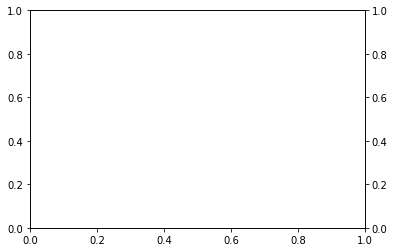

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
def response(input_):
    
    sentenceOutput , actionOutput, emotionOutput = decode_sequence(
        pad_sequences(tokenizer.texts_to_sequences([input_]),maxlen=maxWordsInSentence,))

    return sentenceOutput, actionOutput, emotionOutput

def chat():
    fullText = ""
    
    maxTurn = int(input("turns (1~6) : "));fullText = fullText+ "turns(1~6) : "+str(maxTurn)
    print(".\n\n");fullText += "\n.\n\n"
    
    i = 0
    while(i < maxTurn):
        input_ = input(str(i+1)+" human : ");fullText = fullText+ str(i+1)+" human : "+ input_+"\n"
        _sentenceOutput, _actionOutput, _emotionOutput = response(input_)
        print(str(i+1)+" bot : "+_sentenceOutput);fullText = fullText+str(i+1)+" bot : "+_sentenceOutput+"\n\n"
        #clear_output(wait=True)
        #print(fullText)
        printGraphs(_actionOutput, _emotionOutput)
        sleep(0.01)
        i+=1
    
    print("\n.")
        
def printGraphs(actionOutput,emotionOutput):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4),gridspec_kw = {'width_ratios':[4, 7]})
    
    actions = ('Inform', 'Question', 'Directive', 'Commissive')
    y_pos = np.arange(len(actions))
    barList = ax1.bar(y_pos, actionOutput, align='center', alpha=0.5)
    barList[np.argmax(actionOutput)].set_color("red")
    ax1.set_xticks(y_pos, actions)
    ax1.set_xticklabels([0,'Inform', 'Question', 'Directive', 'Commissive'])
    ax1.set_ylabel('Probability')
    ax1.set_ylim(0,1)
    ax1.set_title('Action analysis')

    
    emotions =('neutral','anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise')
    y_pos = np.arange(len(emotions))
    barList = ax2.bar(y_pos, emotionOutput, align='center', alpha=0.5)
    barList[np.argmax(emotionOutput)].set_color("red")
    ax2.set_xticks(y_pos, emotions)
    ax2.set_xticklabels([0,'neutral','anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise'])
    ax2.set_ylabel('Probability')
    ax2.set_ylim(0,1)
    ax2.set_title('Emotion analysis')

    plt.show()

turns (1~6) : 7
.


1 human : hello? nice to meet you
1 bot : nice to meet you too 


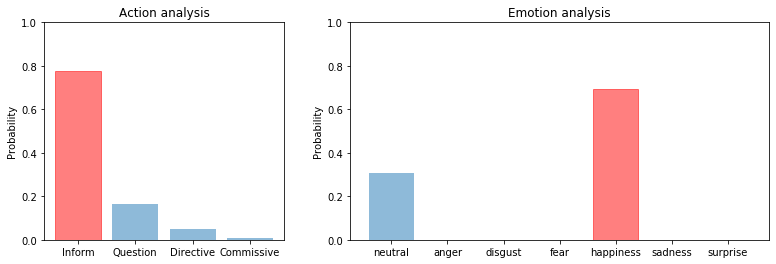

2 human : how are you doing?
2 bot : i ’ m going to be fine 


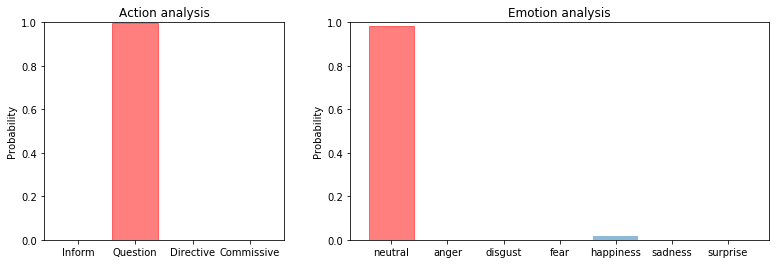

3 human : that's nice!
3 bot : i don't know how about it 


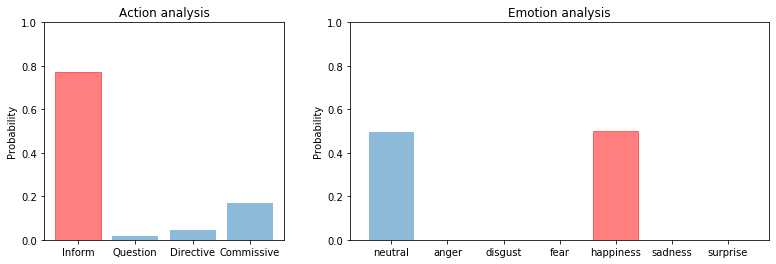

4 human : I'm so sad
4 bot : i don't know i'm not sure 


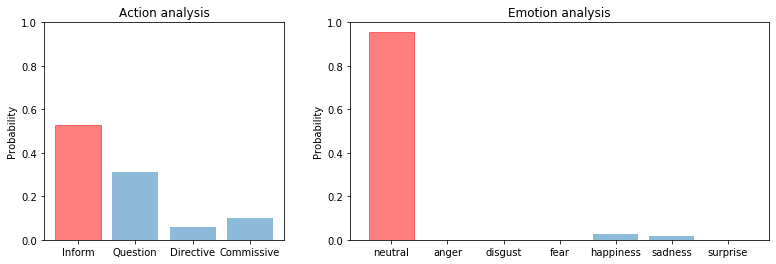

5 human : today is the best day in my life
5 bot : yes it is a good choice 


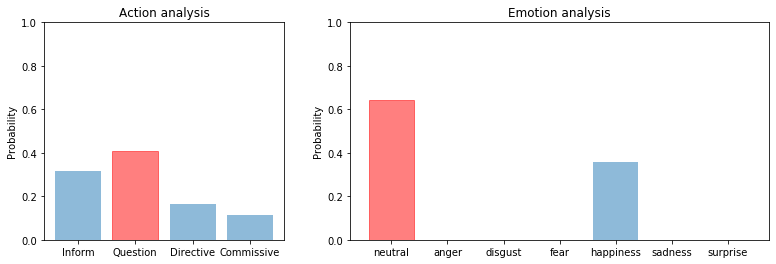

6 human : can you pick me up today?
6 bot : yes 


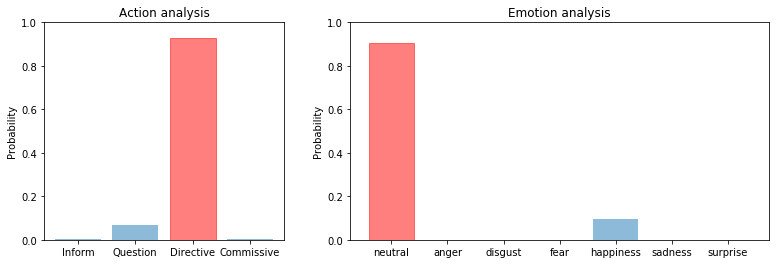

7 human : how old are you?
7 bot : it's a quarter to be a m 


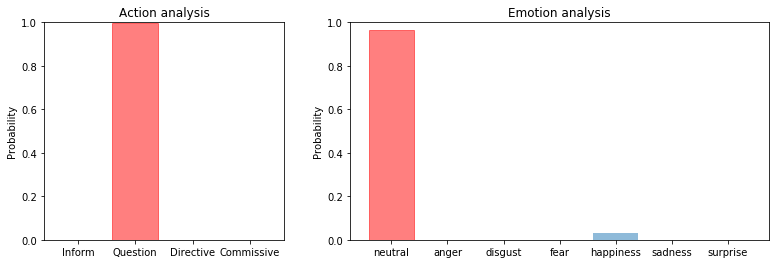


.


In [16]:
chat()


In [0]:
np.random.randint(0, 9, size=(32,5,1))

array([[[6],
        [0],
        [8],
        [8],
        [0]],

       [[2],
        [0],
        [2],
        [5],
        [3]],

       [[3],
        [0],
        [4],
        [1],
        [7]],

       [[6],
        [0],
        [2],
        [4],
        [2]],

       [[2],
        [2],
        [7],
        [0],
        [8]],

       [[1],
        [2],
        [3],
        [7],
        [7]],

       [[8],
        [3],
        [1],
        [5],
        [5]],

       [[7],
        [4],
        [2],
        [1],
        [6]],

       [[7],
        [3],
        [5],
        [2],
        [6]],

       [[8],
        [8],
        [6],
        [5],
        [4]],

       [[0],
        [3],
        [3],
        [0],
        [2]],

       [[2],
        [8],
        [5],
        [0],
        [7]],

       [[6],
        [0],
        [7],
        [6],
        [5]],

       [[5],
        [5],
        [1],
        [2],
        [0]],

       [[1],
        [2],
        [5],
        [6],
        [0